# Resolvendo a equação de tranferência de calor em meio bidimensional.
## Cursos de Verão IFMG-Arcos 2023
### Rotinas computacionais aplicadas às Ciências Térmicas - GESESC
#### Autor: *Reginaldo Gonçalves Leão Junior*

Antes de iniciar a execução do notebook instale o seguinte paconte no ambiente `ct-env`.

```
conda install -c conda-forge ffmpeg
```

Neste notebook resolveremos a equação de transferência de calor:

$$
\frac{\partial u}{\partial t} - \alpha \nabla u = 0
$$

Onde $u$ é a função que determina a distribuição de calor sobre uma chapa planla de espessura deprezível em relação ao seu comprimento e largura, logo pode-se resolver o problema em duas dimensões.

$$
\frac{\partial u}{\partial t} - \alpha \left( \frac{\partial^2 u}{\partial x^2}  + \frac{\partial^2 u}{\partial y^2}\right) = 0
$$

Resolveremos o problema pelo método de diferenças finitas na forma:

$$
f'(a) \approx \frac{f(a+h) - f(a)}{h}
$$

Utilizaremos uma malha muito simples para resolver o problema, composta por um retículado de quadrados idênticos ao 
longo de toda a extensão da placa que será modelada. Conforme a imagem abaixo:

![Malha](eixos.png)
*(Gerado com Geogebra)*

A malha pode ser descrita por:

$$
\begin{cases}
    x_i = i \Delta x; \\
    y_i = i \Delta y; \\
    t_k = k \Delta t; \\
\end{cases}
$$

Para a qual quer-se determinar a função:

$$
u(x, y, t) = u^k_{i,j}
$$

Neste caso, temos o sistema numérico descrito por:

$$
\frac{u^{k+1}_{i,j} - u^{k}_{i,j}}{\Delta t} - \alpha 
\left(
    \frac{u^{k}_{i+1,j} - 2 u^{k}_{i,j} + u^{k}_{i-1,j}}{\Delta x^2} + 
    \frac{u^{k}_{i,j+1} - 2 u^{k}_{i,j} + u^{k}_{i,j-1}}{\Delta y^2}
\right) = 0
$$

Considerando a mesma solução para a $\Delta x$ e $\Delta y$, e utilizando o méto de estêncil para o problema o operador diferencial numérico pode ser escrito na forma:

$$
u^{k+1}_{i,j} = \gamma(u^{k}_{i+1,j} + u^{k}_{i-1,j} + u^{k}_{i,j+1} + u^{k}_{i,j-1} - 4u^{k}_{i,j}) + u^{k}_{i,j}
$$

onde:

$$
\gamma = \alpha \frac{\Delta t}{\Delta x^2}
$$

e a condição de estabilidade numérica apra os valores de $t$ é dada por:

$$
\Delta t \leq \frac{\Delta x^2}{4 \alpha}
$$

Vamos iniciar a implementação do problema pela importação das bibliotecas. Aqui usaremos módulos ligeiramente diferentes dos habituais pois faremos algumas animações. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Em seguida definimos os parâmetros do modelo. 
Neste caso uma chapa quadrada de comprimento 50 unids, 1000 iterações para a solução do problema e condições de contorno dadas por:

1. Temperatura superior: 100 ut
2. Demais temperaturas: 0 ut

Além disso ainda estabeleceremos a temperatura no centro do grid também como nula.

In [2]:
comp_chapa = 50
max_iter_temp = 1000
u_interno = 0.0
u_sup = 100.0
u_esq = 0.0
u_baixo = 0.0
u_dir = 0.0

Além disso, estabeleceremos um $\Delta x = \Delta y$ unitário e um coeficiente de difusão igual a dois.

In [3]:
alpha = 2.0
delta_x = 1

Agora os parâmetros numéricos podem ser calculados, para o valor de $\Delta t$ faz-se:

In [4]:
delta_t = (delta_x ** 2)/(4 * alpha)

E para o valor de $\gamma$ faz-se:

In [5]:
gamma = (alpha * delta_t) / (delta_x ** 2)

A malha é criada inicialmente vazia e então posteriormente preenchida com os valores de $u(x, y, t) = u^k_{i,j}$ para o tempo igual a zero.

In [6]:
u = np.empty((max_iter_temp, comp_chapa, comp_chapa))
u.fill(u_interno)

A malha pode ser inspecionada da seguinte forma:

In [7]:
u

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Agora vamos adicionar as condições de contorno à malha.

In [8]:
u[:, (comp_chapa-1):, :] = u_sup
u[:, :, :1] = u_esq
u[:, :1, 1:] = u_baixo
u[:, :, (comp_chapa-1):] = u_dir

O método de diferenças finitas é implementado da seguinte forma:

In [13]:
def fem_method(u):
  for k in range(0, max_iter_temp-1, 1):
    for i in range(1, comp_chapa-1, delta_x):
      for j in range(1, comp_chapa-1, delta_x):
        u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  
  return u

Note a iteração em cada um dos eixos, inciando por $y$, $x$ e em seguida $t$.

Então se faz o cálculo de $u$. (Pode levar um tempinho...)

In [15]:
u = fem_method(u)

Para exibir a evolução temporal da propagação de calor utiliza-se uma função que realiza a plotagem dos dados e que será atualizada a cada iteração. 

In [10]:
def plotheatmap(u_k, k):
  # Clear the current plot figure
  plt.clf()
  plt.title(f"Temperatura em t = {k*delta_t:.3f} unit time")
  plt.xlabel("x")
  plt.ylabel("y")
  
  # This is to plot u_k (u at time-step k)
  plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
  plt.colorbar()
  
  return plt

A animação do processo é criada. (Pode levar outro tempinho...)

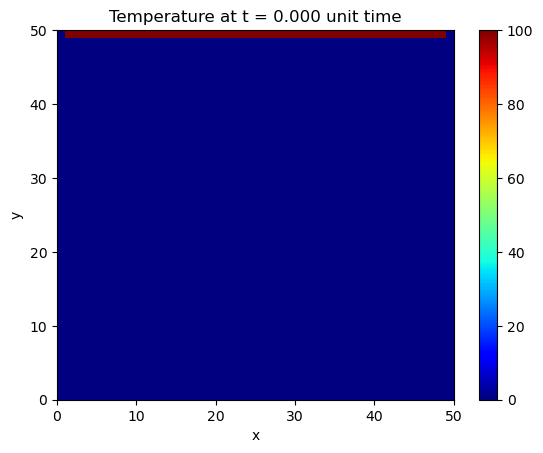

In [22]:
def animate(k):
    plotheatmap(u[k], k)
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_temp, repeat=True)

MovieWriter ffmpeg unavailable; using Pillow instead.


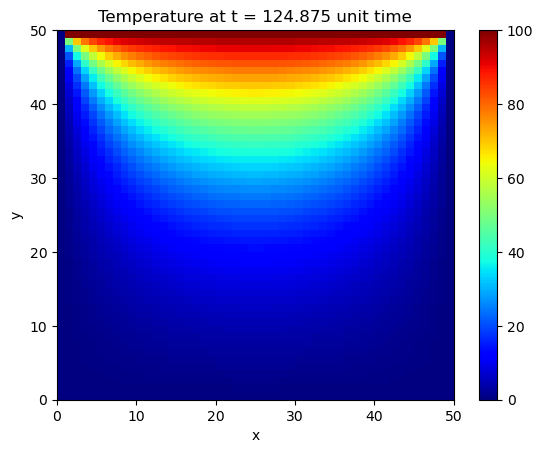

In [23]:
anim.save("solucao_equacao_calor.gif")

## Atividade
Modifique as condições de contorno para tentar uma nova simulação e veja o resultado. 

``` Python
u_sup = 0.0
u_esq = 0.0
u_baixo = 0.0
u_dir = 0.0

u_interno = np.random.uniform(low=28.5, high=55.5, size=(plate_length,plate_length))

u[0,:,:] = u_interno
```